# Dependencies and libraries 

In [1]:
import cobra
import re
from pprint import pprint
import pandas as pd
import numpy as np
import copy
import os 
import sklearn 
import matplotlib.pyplot as plt



In [2]:
#set directory and load models
os.chdir('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/Mitocore/Human1_coverage/KEGG_Modules/generated_files')
mitocore = cobra.io.read_sbml_model("/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/Mitocore/Human1_coverage/Cleaned_Mitocore_changed_metabolites_metanetx.chemical.xml")
human1 = cobra.io.read_sbml_model("/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/Mitocore/Human1_coverage/Human-GEM.xml")


In [ ]:
def sort_kegg_ids (model,target_db):
    """Extract reaction id for a target database from a defined model, if >1 id 
    add all ids as new entries.

    model: COBRApy model (not an .xml file but already loaded as a model)
    target_db: database key in the annotations of the model
    """
    import re
    pattern=r'R\d{5}' #Pattern KEGG ids recognition (e.g. R00209)

    kegg_react={'model_id':[], target_db:[]}

    #get reaction annotations from an object (loaded model)
    reactions= getattr(model , 'reactions')
    for reaction in reactions:
        target_id=reaction.annotation.get(target_db)

         # Normalize annotation value to string
        if isinstance(target_id, list):
            target_id = ' '.join(target_id)
        else:
            target_id = str(target_id)

        # Find all KEGG ids (e.g. R00209, R01324, etc.)
        matches = re.findall(pattern, target_id) #re.findall() works just with str
        for match in matches:
            kegg_react['model_id'].append(reaction.id)
            kegg_react[target_db].append(match)

    return pd.DataFrame.from_dict(kegg_react)

def kegg_API_req(model,input_df,input_id, target ,target_rest, split_pat):
    """ Function for API request to obtain KEGG module per reaction

    model: str, name of the model of interest
    input_df: dataframe with KEGG ids.
    target_db: target in KEGG to look for, position [0]. (e.g. 'kegg.module', 'kegg.reaction')
    target_rest: residue in the same line of target_db, position [1]. 
    split_pat: pattern to split when processing response. (e.g. 'PATHWAY', 'MODULE')
    """
    import pandas as pd
    import ssl  # certificates needed to access KEGG API 
    from urllib import request  

    output_dict = {'model_id': [], target: [], target_rest: []}
    ssl._create_default_https_context = ssl._create_unverified_context #create the certificate

    kegg_attr = list(input_df.loc[:,input_id])
    model_id = list(input_df.loc[:,'model_id'])


    batch_size = 10

    counter = 0

    for batch in range(0, len(kegg_attr), batch_size):

        url = 'https://rest.kegg.jp/get/'
        batch_index = 0
        batch_entries = []
        
        while(batch + batch_index < len(kegg_attr) and batch_index < batch_size):
            
            batch_entries.append(kegg_attr[batch + batch_index])
            url += kegg_attr[batch + batch_index]
            
            if batch_index < batch_size-1:
                url+='+'
            
            batch_index += 1

        req = request.Request(url)
        with request.urlopen(req) as f:
            response = f.read()
        response_string_list = response.decode('utf-8').splitlines()

        reading_pathway_section = False
        gene_has_pathways = False

        entry_index = 0

        for line in response_string_list:

            if line == '///':
                if not gene_has_pathways:
                    output_dict['model_id'].append(model_id[counter])
                    output_dict[target].append('')
                    output_dict[target_rest].append('')

                print('attr:', counter + 1, 'of', len(kegg_attr), end='\r')

                entry_index += 1
                counter += 1
                reading_pathway_section = False
                gene_has_pathways = False
                continue
            
            if reading_pathway_section and not line.startswith(' '):
                reading_pathway_section = False

            if line.startswith(split_pat):
                reading_pathway_section = True
                gene_has_pathways = True
                line = line.split(split_pat)[1]
            
            if reading_pathway_section:
                line_split = line.strip().split('  ')

                output_dict['model_id'].append(model_id[counter])
                output_dict[target].append(line_split[0])
                output_dict[target_rest].append(line_split[1])

        
        
    return pd.DataFrame.from_dict(output_dict).to_csv(f"{target}_{model}.csv", index=False)

def sort_kegg_ids_human1 (model,target_db ):
    """Extract reaction id for a target database from human1, if >1 id 
    add all ids as new entries.

    -model: COBRApy model 
    -target_db: database key in the annotations of the model
    """
    import re
    pattern=r'R\d{5}'

    kegg_react={'model_id':[], target_db:[]}

    reactions= getattr(model , 'reactions')
    for ann in reactions:
        #human1_c_e_m is a list with all reactions in compartments c,e,m 
        if ann in human1_c_e_m: 
            target_id=ann.annotation.get(target_db)

            # Normalize annotation value to string
            if isinstance(target_id, list):
                target_id = ' '.join(target_id)
            else:
                target_id = str(target_id)

            # Find all KEGG IDs (e.g., R00209, R01324, etc.)
            matches = re.findall(pattern, target_id) #re.findall() works just with str
            for match in matches:
                kegg_react['model_id'].append(ann.id)
                kegg_react[target_db].append(match)

    return pd.DataFrame.from_dict(kegg_react)

def extract_modules(modes_model1,modes_model2):
    """function to extract all the modules for 2 models.

    -modes_model1: .csv file with modes from model 1.
    -modes_model2: .csv file with modes from model 2

    returns: dataframe with all modules from both models (2 columns: module id, module name)
    """

    modules_total={'module':[], 'module name':[]}
    for index, row in modes_model1.iterrows():
        module= row['kegg.module']
        name= row['module_name']

        if pd.notna(module):
            modules_total['module'].append(module)
            modules_total['module name'].append(name)

    for index, row in modes_model2.iterrows():
        module= row['kegg.module']
        name= row['module_name']

        if pd.notna(module):
            modules_total['module'].append(module)
            modules_total['module name'].append(name)

    return pd.DataFrame(modules_total)

def kegg_API_modul_content(input_df, input_id, target):
    """ Function to perform KEGG API request to obtain all KEGG reactions contained in a KEGG module
   
    -input_df: dataframe with KEGG module ids.
    -target_db: name of column with modules in input_df
    -target: target (whole reaction response per module)

    returns: dataframe with all reactions per module (2 columns: module id, whole content of the module (reactions, compounds, enzymes))
    """
    
    import pandas as pd
    import ssl
    from urllib import request

    ssl._create_default_https_context = ssl._create_unverified_context

    output_dict = {'module_id': [], target: []}

    kegg_attr = list(input_df[input_id])
    batch_size = 10

    for batch in range(0, len(kegg_attr), batch_size):

        batch = kegg_attr[batch:batch + batch_size]
        url = "https://rest.kegg.jp/get/" + "+".join(batch)

        with request.urlopen(url) as f:
            lines = f.read().decode("utf-8").splitlines()

        #flags and collecting list
        current_module = None
        is_hsa = False
        collecting_reactions = False
        reaction_buffer = []

        for line in lines:

            # start a new module from batch 
            if line.startswith("ENTRY"):
                # reset state for new module
                current_module = line.split()[1] # extract module id from line: (ENTRY       M00155            Pathway)
                is_hsa = False
                collecting_reactions = False
                reaction_buffer = []

            # check if module is human from line: (COMPLETE    hsa  Homo sapiens (human))
            elif line.startswith("COMPLETE"):
                if "hsa" in line:
                    is_hsa = True

            # start reaction collection only if module is human
            elif line.startswith("REACTION") and is_hsa:
                 # collect continuation lines
                collecting_reactions = True
                reaction_buffer = [line[len("REACTION"):].strip()]

            # stop when a new block starts 
            elif collecting_reactions:
                if line.startswith(("COMPOUND", "ENZYME", "NAME", "ENTRY", "CLASS", "DEFINITION", "PATHWAY", "MODULE", "ORTHOLOGY", "REFERENCE", "COMMENT")):
                    collecting_reactions = False
                else:
                    reaction_buffer.append(line.strip())

            # end of module
            # write only if human
            if line == "///":
                if is_hsa:
                    result = " ".join(reaction_buffer).strip()
                    output_dict["module_id"].append(current_module)
                    output_dict[target].append(result)

                # reset for next module
                current_module = None
                is_hsa = False
                collecting_reactions = False
                reaction_buffer = []

    df = pd.DataFrame(output_dict)
    df.to_csv("modules_content_hsa.csv", index=False)
    return df

def module_coverage_index(csv_reactions_model, dict_with_modules_react, csv_modules_model):
    """ function to calculate the coverage index of a model based on KEGG modules

    -csv_reactions_model: .csv file with all reactions in the model and the reactions KEGG ids
    -dict_with_modules_react: dictionary with all modules as key and all reactions of the module as values
         dict {'M00549': ['R01786, R02189, R00959, R00289']}
    -csv_modules_model: .csv file with all modules in the model 

    returns: dataframe with coverage index per module (2 columns: module id, coverage index)
    """
    import re
    
    # read csv with reactions and modules in model
    reactions_mod = pd.read_csv(csv_reactions_model)  
    modules_model = pd.read_csv(csv_modules_model)
    # avoid duplicate module ids from the csv file 
    modules_model_ids = list(modules_model['kegg.module'].unique())

    # discard duplicates from the reactions list
    reactions = list(set(reactions_mod['kegg.reaction']))
    modules = dict_with_modules_react
    #open collecting dict
    coverage_dict = { 'module id': [], 'module name': [], 'coverage': []}

    # loop over modules in list of modules from the model
    for module_id in modules_model_ids:
        # check if module is in mapping dict
        if module_id in modules:

            name_series = modules_model.loc[modules_model['kegg.module'] == module_id, 'module_name']
            name = name_series.values[0] if len(name_series) > 0 else 'Unknown'
            # normalize stored value into a list of R00000 ids
            raw = modules[module_id]
            if isinstance(raw, str):
                react_in_module = re.findall(r'R\d{5}', raw)
            elif isinstance(raw, (list, tuple)):
                # join then extract (handles list of one id or list of ids as str)
                joined = " ".join(str(x) for x in raw)
                react_in_module = re.findall(r'R\d{5}', joined)
            else:
                # make a list out of it
                try:
                    react_in_module = list(raw)
                except Exception:
                    react_in_module = []
            #calculate total number of reactions in a module 100%
            total_react_in_module = len(react_in_module)
            print(f"module {module_id} has {total_react_in_module} reactions")
            # handle cases of empty modules
            if total_react_in_module == 0:
                coverage_dict['module id'].append(module_id)
                coverage_dict['module name'].append(name)
                coverage_dict['coverage'].append(0)
                continue
            # count how many reactions from the module are in the model
            react_set = set(react_in_module)
            counter = sum(1 for reaction in reactions if reaction in react_set)
            coverage = counter / total_react_in_module

            # store coverage ratio once per module
            coverage_dict['module id'].append(module_id)
            coverage_dict['module name'].append(name)
            coverage_dict['coverage'].append(coverage)
            
    return pd.DataFrame(coverage_dict)

# Processing Mitocore reactions to extract KEGG modules
1. Extract KEGG ids from Mitoocore and Mitocore ids into dataframe
2. Api request to obtain KEGG modules for this KEGG ids


In [111]:
# 1. Processing Mitocore KEGG ids calling functions
kegg_mito=sort_kegg_ids(mitocore,'kegg.reaction')
print('lenght: ', len(kegg_mito))
pd.DataFrame(kegg_mito).to_csv('kegg_reactions_mito.csv')

# 2. API calling function
kegg_API_req('mitocore', kegg_mito,'kegg.reaction', 'kegg.module','module_name', 'MODULE')



lenght:  360


# Processing Human1 reactions

1. Extract just reactions from (Cytosol, Extracelular,Mitochondria) to make Human1 comparable to Mitocore
2. KEGG ids from Mitoocore and Mitocore ids into dataframe
3. API request to obtain KEGG modules for this KEGG ids and save into csv



In [112]:
# 1.Extract just reactions from c,e,m compartments)
allowed = {'c', 'm', 'e'}
human1_c_e_m = [
    reaction for reaction in human1.reactions
    if {met.compartment for met in reaction.metabolites}.issubset(allowed)
]
print(len(human1_c_e_m))

9612


In [113]:
# 2. KEGG ids from Mitoocore and Mitocore ids into dataframe
kegg_human1=sort_kegg_ids_human1 (human1,'kegg.reaction')
print('lenght: ', len(kegg_mito))

df_human1 = kegg_human1[kegg_human1['kegg.reaction'].notna()]
print('lenght: ', len(kegg_human1))


lenght:  360
lenght:  1850


In [ ]:
# 3. API request to obtain KEGG modules for this KEGG ids
pd.DataFrame(df_human1).to_csv('kegg_reactions_human1.csv')
kegg_API_req('human1',df_human1,'kegg.reaction', 'kegg.module','module_name', 'MODULE')

# Filter human modules 
1. read modules MitoCore and Human1
2. unite into one unique KEGG modules dataframe 
3. extract modules from dataframe into list for API request
4. API request for KEGG module content (just human modules)
5. create mapping dictionary (just human modules)
5. filter just human modules from datafram in 3. with mapping df in 5. 

In [ ]:
# 1.  read modules for Mitocore and Human1 from API request 
modules_mito= pd.read_csv('kegg.module_mitocore.csv')
modules_human1= pd.read_csv('kegg.module_human1.csv')

# 2. Unique KEGG modules Mitocore, Human1 drop duplicates
total_modules= extract_modules(modules_mito,modules_human1)
total_modules= total_modules.drop_duplicates()
print(len(total_modules))

# 3. extract modules into a list for API request of module content
modules_total = list(total_modules['module'])
modules_total_df = pd.DataFrame(modules_total, columns=['module'])
print(modules_total_df)

227
     module
0    M00001
1    M00549
2    M00002
3    M00003
4    M00165
..      ...
222  M00898
223  M00124
224  M00103
225  M00538
226  M01047

[227 rows x 1 columns]


In [ ]:
# 4. API request for KEGG modules
Modules_response=kegg_API_modul_content(modules_total_df, 'module', 'reactions')

In [ ]:
# 5. Create dictionary with strcture
#  {'M00549': ['R01786, R02189'], 'M00002': ['R01015, R07159']}
module_reactions = pd.read_csv('modules_content_hsa.csv') 

import re
pattern = r'R\d{5}'  # Pattern KEGG ids recognition (e.g. R00209)
modules_dict = {}

for index, row in module_reactions.iterrows():
    module = row['module_id']
    reactions = str(row['reactions'])  # Convert reactions to string
    matches = re.findall(pattern, reactions)  # re.findall() works just with str
    if matches:
        if module not in modules_dict:
            modules_dict[module] = []  # Initialize the list for the module
        modules_dict[module].append(', '.join(matches))  # Join matches into a single string

print(modules_dict)

{'M00001': ['R01786, R02189, R09085, R13199, R00756, R05805, R01068, R01015, R01061, R01063, R01512, R07159, R01518, R00658, R00200'], 'M00549': ['R01786, R02189, R00959, R00289'], 'M00002': ['R01015, R01061, R01063, R01512, R07159, R01518, R00658, R00200'], 'M00003': ['R00431, R00726, R00341, R00658, R01518, R01512, R01061, R01063, R01015, R01068, R00762'], 'M00004': ['R02736, R10907, R02035, R01528, R10221, R01529, R01056, R01641, R08575, R01067, R13199, R02739'], 'M00006': ['R02736, R10907, R02035, R01528, R10221'], 'M00007': ['R01067, R08575, R01641, R01529, R01056'], 'M00307': ['R00209, R01196, R00014, R03270, R02569, R07618'], 'M00009': ['R00351, R01325, R01900, R01324, R01899, R00268, R00267, R00709, R00621, R03316, R01700, R02570, R07618, R01197, R00405, R00432, R00727, R10343, R02164, R01082, R00342, R00361'], 'M00011': ['R00621, R03316, R01700, R02570, R07618, R01197, R00405, R00432, R00727, R10343, R02164, R01082, R00342, R00361'], 'M00032': ['R00716, R02313, R03102, R03103,

In [ ]:
# 6. Filter just human modules 
human_modules = {'module': [], 'module_name': []}
for index, row in total_modules.iterrows():
    module = row['module']
    module_name = row['module name']
    if module in modules_dict.keys():
        human_modules['module'].append(module)
        human_modules['module_name'].append(module_name)
    else:
        print('module not found in human1:', module)

# Convert the dictionary to a DataFrame and then drop duplicates
human_modules = pd.DataFrame(human_modules).drop_duplicates()
print('Total human modules found:', len(human_modules))
          
print(human_modules)

module not found in human1: M00165
module not found in human1: M00308
module not found in human1: M00552
module not found in human1: M00346
module not found in human1: M00008
module not found in human1: M00580
module not found in human1: M00012
module not found in human1: M00740
module not found in human1: M00173
module not found in human1: M00374
module not found in human1: M00620
module not found in human1: M00376
module not found in human1: M00982
module not found in human1: M00168
module not found in human1: M00171
module not found in human1: M00149
module not found in human1: M00150
module not found in human1: M00155
module not found in human1: M00156
module not found in human1: M00157
module not found in human1: M00159
module not found in human1: M00169
module not found in human1: M00172
module not found in human1: M00170
module not found in human1: M00375
module not found in human1: M00957
module not found in human1: M00088
module not found in human1: M00373
module not found in 

# Presence-absence Map for Human KEGG modules in Mitocore and Human1

1. set presence-absence matrix 
2. plot the presence-absence map




In [ ]:
# 1. KEGG module presence-absence array 

#dictionary, catch flags in modules for the respective model
mitocore_flags = []
human1_flags = [] 

# discard duplicates from the modules
mito_modules = set(modules_mito['kegg.module'])
human1_modules = set(modules_human1['kegg.module'])

#extract 'modules' row from df for all modules (Humanq1 + Mitocore)
for index, row in human_modules.iterrows():
    module = row['module']
    if module and pd.notna(module):
    #conditional = 1 if module in total modules in Mitocore or Human1 
        mitocore_flags.append(1 if module in mito_modules else 0)
        human1_flags.append(1 if module in human1_modules else 0)

# Add new columns to dataframe
human_modules['Mitocore'] = mitocore_flags
human_modules['Human1'] = human1_flags

print(human_modules)
human_modules.to_csv('kegg_modules_presence_absence.csv', index=False)

     module                                        module_name  Mitocore  \
0    M00001  Glycolysis (Embden-Meyerhof pathway), glucose ...         1   
1    M00549               UDP-Glc biosynthesis, Glc => UDP-Glc         1   
2    M00002  Glycolysis, core module involving three-carbon...         1   
3    M00003       Gluconeogenesis, oxaloacetate => fructose-6P         1   
4    M00004  Pentose phosphate pathway (Pentose phosphate c...         1   
..      ...                                                ...       ...   
101  M00132  Inositol phosphate metabolism, Ins(1,3,4)P3 =>...         0   
102  M00880  Molybdenum cofactor biosynthesis, GTP => molyb...         0   
103  M00842       Tetrahydrobiopterin biosynthesis, GTP => BH4         0   
104  M00037  Melatonin biosynthesis, animals, tryptophan =>...         0   
105  M00103                       Cholecalciferol biosynthesis         0   

     Human1  
0         1  
1         1  
2         1  
3         1  
4         1  
.. 


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20

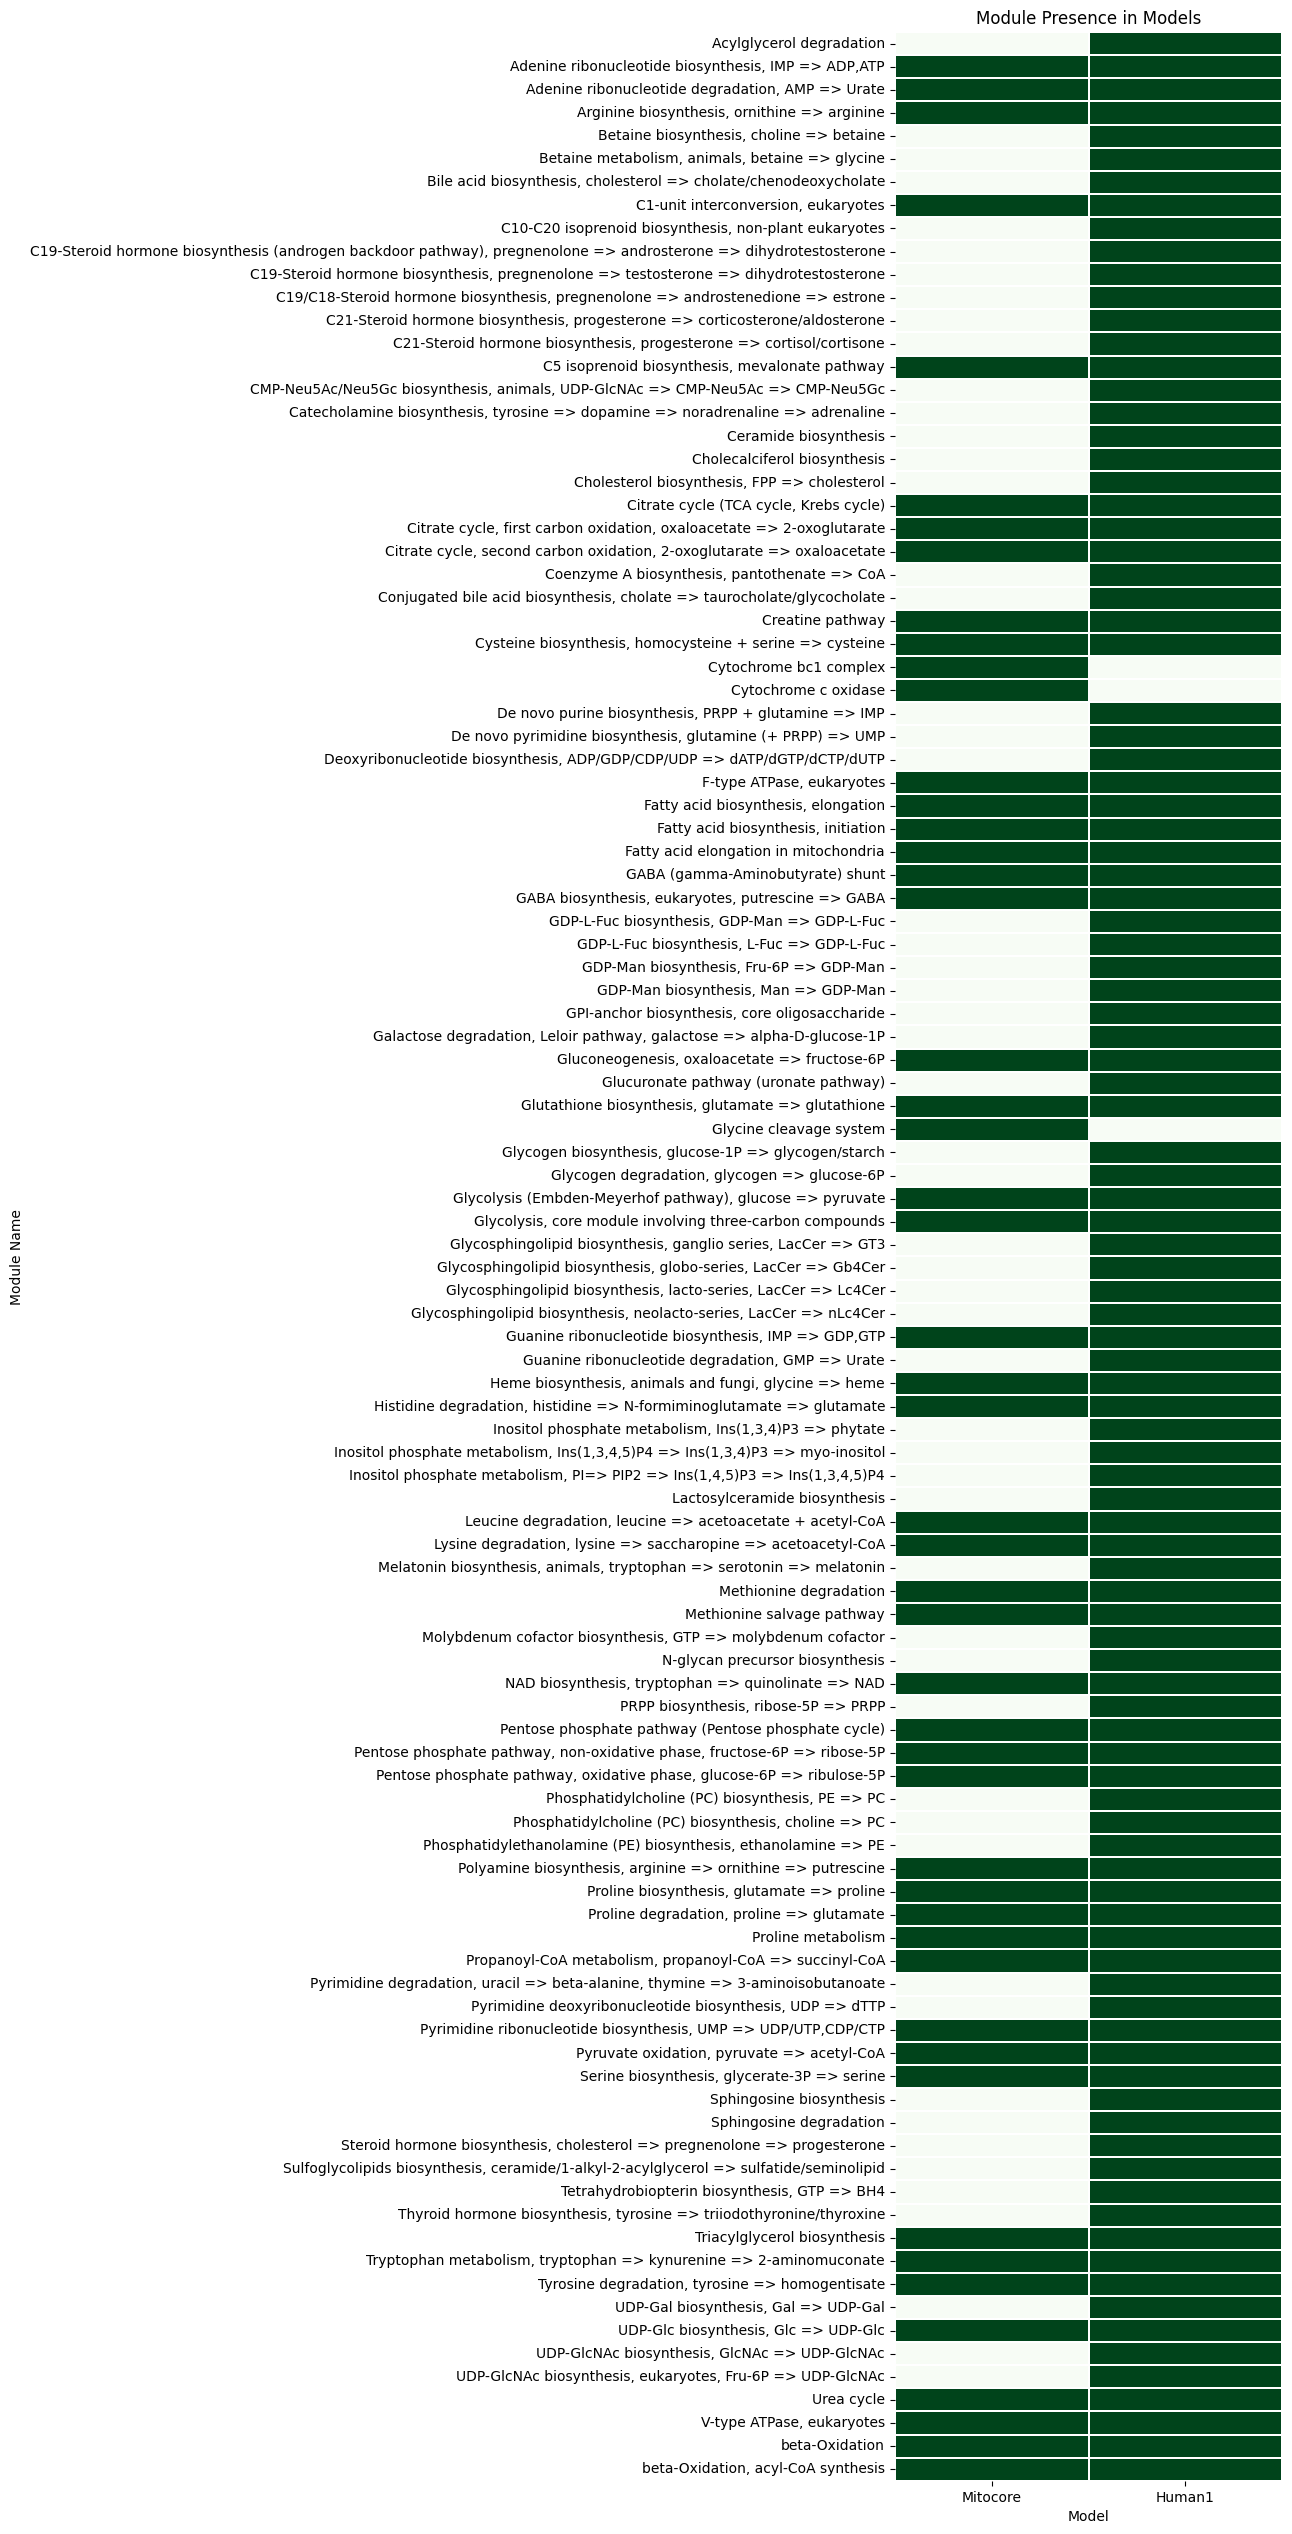

In [ ]:
# 2. Plot presence-absence map
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

print(plt.colormaps())

heatmap_data = human_modules.set_index('module_name')[['Mitocore', 'Human1']].sort_index(axis=0)

# Create the heatmap
plt.figure(figsize=(5, len(heatmap_data) * 0.3))  # Adjust height to number of modules
sns.heatmap(heatmap_data, cmap='Greens', cbar=False, linewidths=0.1)

plt.title('Module Presence in Models')
plt.xlabel('Model')
plt.ylabel('Module Name')
#plt.tight_layout()
plt.show()

# KEGG Module coverage per model as Heatmap 

1. calculate coverage index and set matrix for ploting
2. Plot heatmap with coverage index




In [ ]:
# 1. calculate coverage index
modules_mito=module_coverage_index('kegg_reactions_mito.csv', modules_dict, 'kegg.module_mitocore.csv' )
modules_hum=module_coverage_index('kegg_reactions_human1.csv', modules_dict, 'kegg.module_human1.csv' )

modules_mito = modules_mito.rename(columns={'coverage': 'Mitocore'})
modules_hum = modules_hum.rename(columns={'coverage': 'Human1'})

# Merge on module id, keep all modules from both models
df_combined = pd.merge( modules_hum[['module id', 'module name', 'Human1']], modules_mito[['module id','module name', 'Mitocore']], on='module name', how='outer' )

# Optional: set module name as index for plotting
df_combined = df_combined.set_index('module name')
df_combined=df_combined.sort_index(axis=0)

print('lenght:', len(df_combined), df_combined)

module M00001 has 15 reactions
module M00549 has 4 reactions
module M00002 has 8 reactions
module M00003 has 11 reactions
module M00004 has 12 reactions
module M00006 has 5 reactions
module M00007 has 5 reactions
module M00307 has 6 reactions
module M00009 has 22 reactions
module M00011 has 14 reactions
module M00032 has 14 reactions
module M00036 has 9 reactions
module M00010 has 8 reactions
module M00152 has 1 reactions
module M00154 has 1 reactions
module M00158 has 1 reactions
module M00160 has 1 reactions
module M00050 has 5 reactions
module M00049 has 5 reactions
module M00086 has 1 reactions
module M00087 has 28 reactions
module M00085 has 28 reactions
module M00095 has 7 reactions
module M00082 has 5 reactions
module M00083 has 35 reactions
module M00741 has 3 reactions
module M00034 has 14 reactions
module M00035 has 5 reactions
module M00338 has 2 reactions
module M00038 has 7 reactions
module M00912 has 10 reactions
module M00970 has 4 reactions
module M00972 has 5 reactions

/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_86673/421752459.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

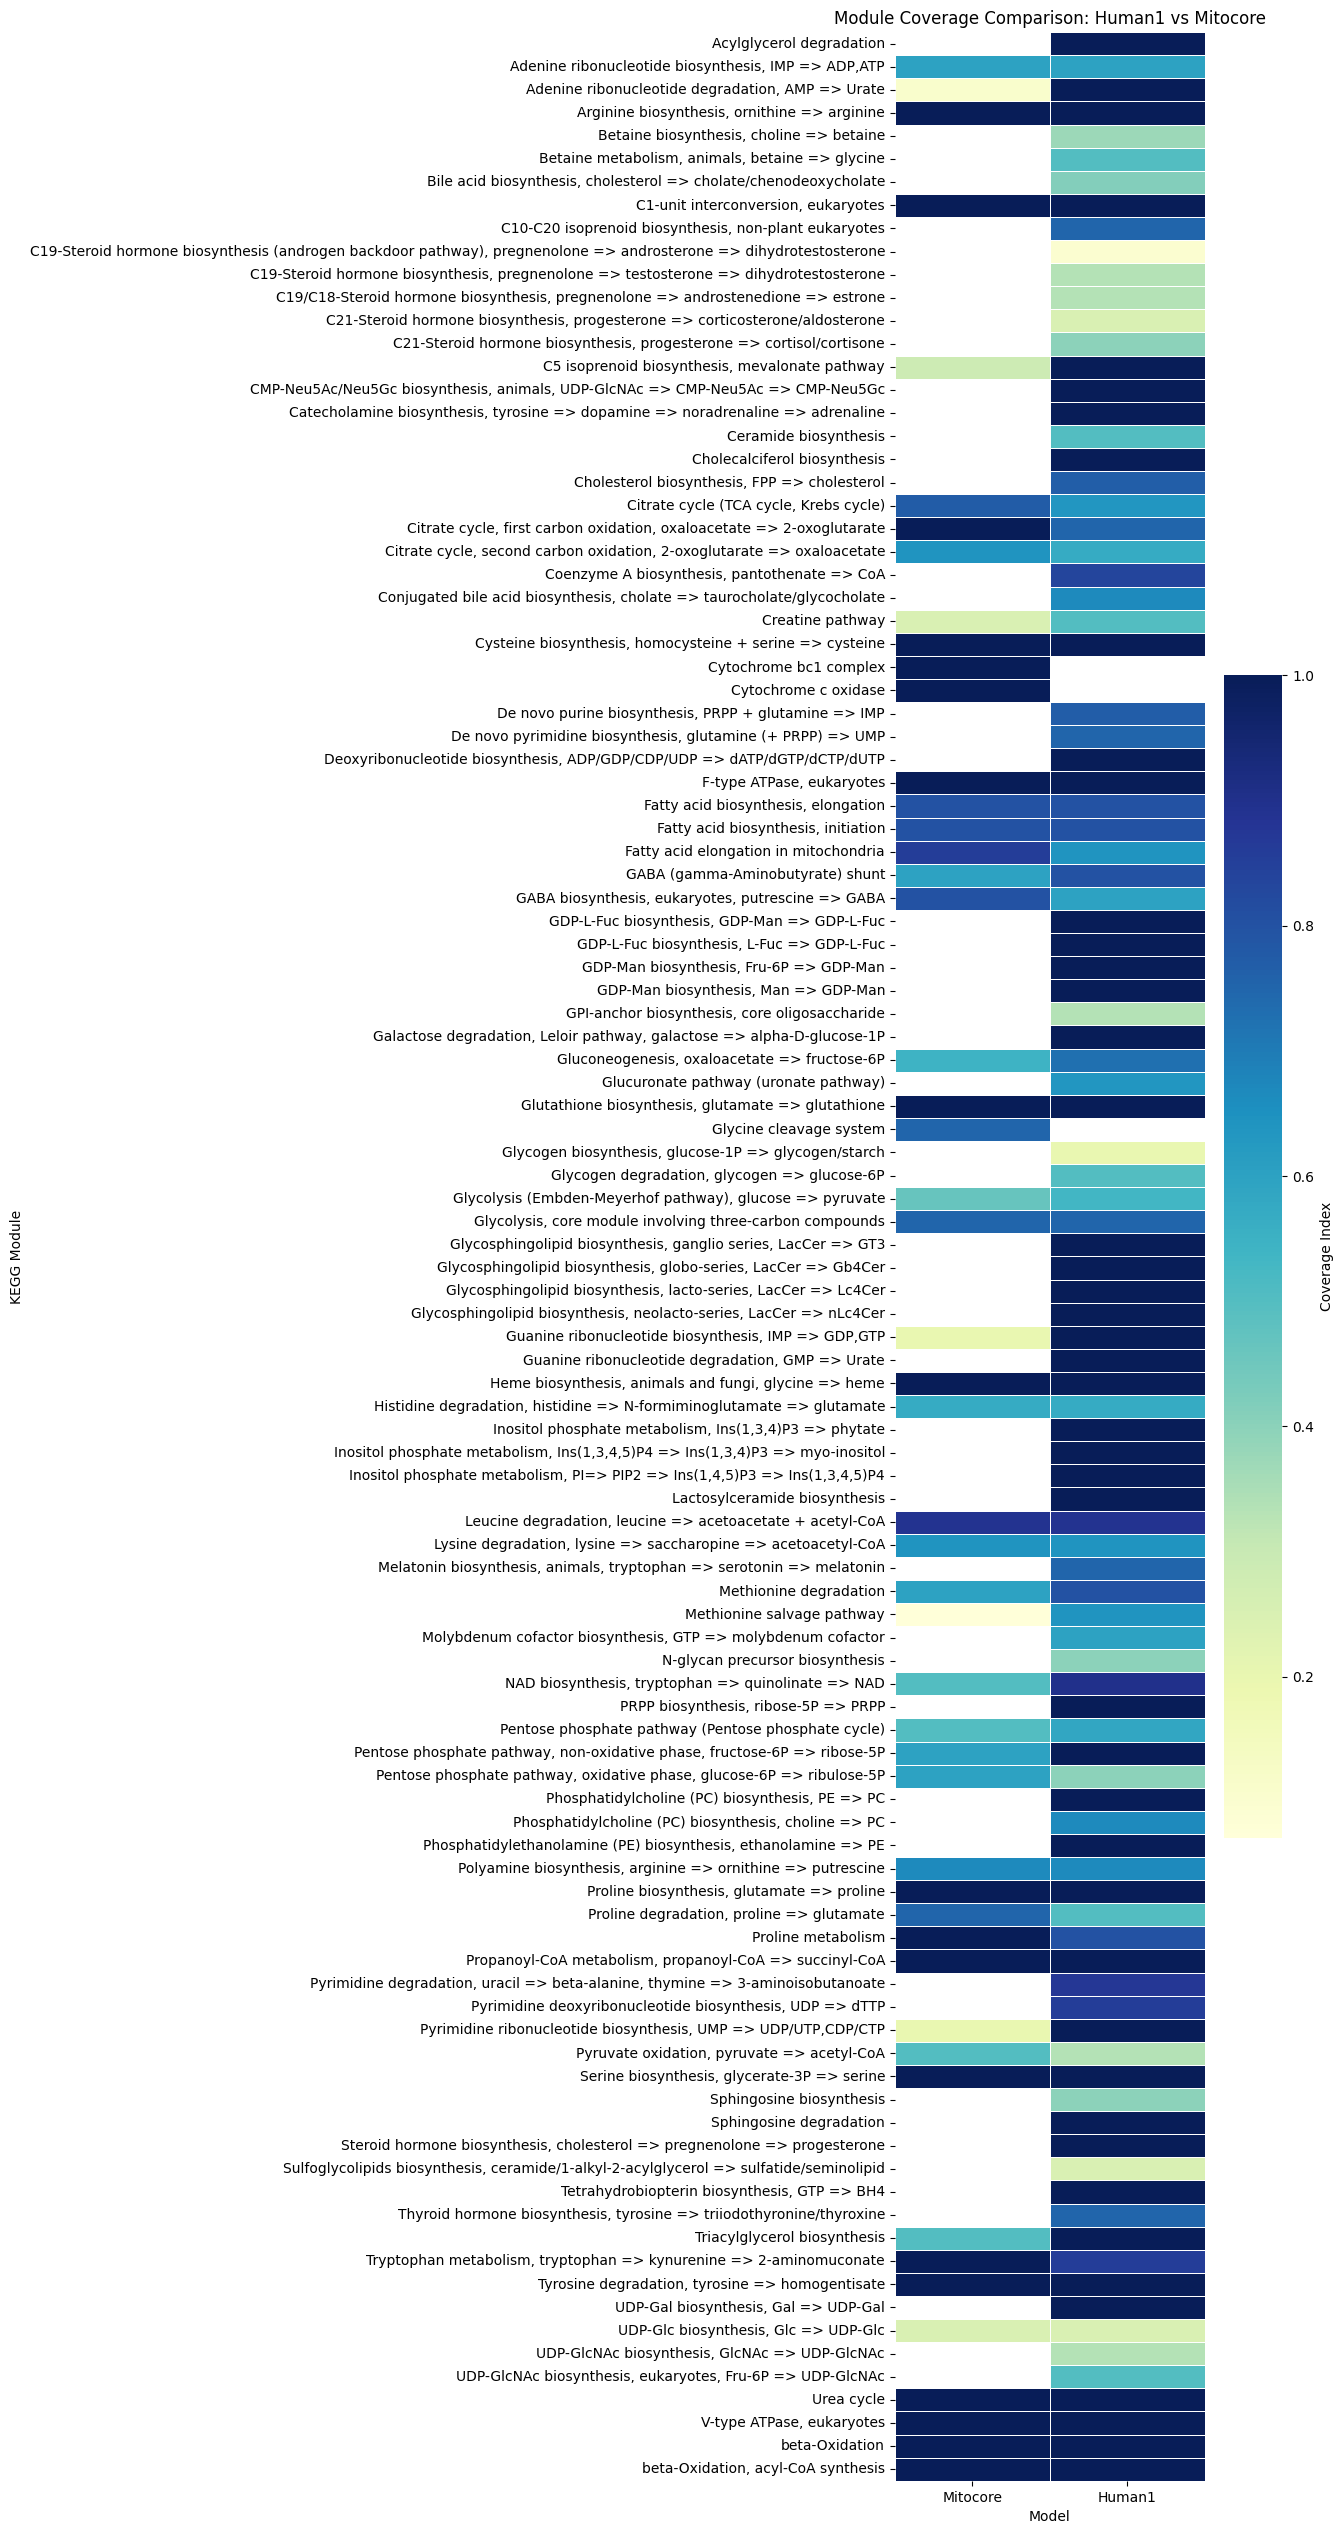

In [ ]:
# 2. Plot coverage index
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# Select only numerical columns for the heatmap
heatmap_data = df_combined[['Mitocore', 'Human1']]

plt.figure(figsize=(5, len(heatmap_data) * 0.3)) # Adjust height to number of modules
sns.heatmap(
    heatmap_data,
    annot=False,  # show numbers inside cells
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Coverage Index'}
)
plt.title("Module Coverage Comparison: Human1 vs Mitocore")
plt.ylabel("KEGG Module")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

# ----------------Checkpoint-----------------------
# check module specific coverage for Glycolisis pathway in MitoCore and Human1

In [ ]:
os.chdir('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/Mitocore/Human1_coverage/KEGG_Modules/generated_files')

In [ ]:
# 1. Create dictionary froma all KEGG modules with strcture
#  {'M00549': ['R01786, R02189'], 'M00002': ['R01015, R07159']}
module_reactions = pd.read_csv('modules_content_hsa.csv') 

import re
pattern = r'R\d{5}'  # Pattern KEGG ids recognition (e.g. R00209)
modules_dict = {}

for index, row in module_reactions.iterrows():
    module = row['module_id']
    reactions = str(row['reactions'])  # Convert reactions to string
    matches = re.findall(pattern, reactions)  # re.findall() works just with str
    if matches:
        if module not in modules_dict:
            modules_dict[module] = []  # Initialize the list for the module
        modules_dict[module].append(', '.join(matches))  # Join matches into a single string

# 2.Convert the dictionary to a DataFrame 
modules = pd.DataFrame.from_dict(modules_dict, orient='index')
modules.columns = ['reactions']
modules.index.name = 'module'
print(modules)



                                                reactions
module                                                   
M00001  R01786, R02189, R09085, R13199, R00756, R05805...
M00549                     R01786, R02189, R00959, R00289
M00002  R01015, R01061, R01063, R01512, R07159, R01518...
M00003  R00431, R00726, R00341, R00658, R01518, R01512...
M00004  R02736, R10907, R02035, R01528, R10221, R01529...
...                                                   ...
M00132                             R03429, R03478, R05202
M00880             R09394, R11372, R09395, R09726, R09735
M00842     R00428, R05046, R05048, R04639, R04286, R08208
M00037                     R01814, R02701, R02911, R03130
M00103                             R03311, R03611, R03610

[106 rows x 1 columns]


In [ ]:
# 3.  read modules for Mitocore and Human1 from API request 
modules_mito= pd.read_csv('kegg.module_mitocore.csv')
modules_human1= pd.read_csv('kegg.module_human1.csv')

# 4. Unique KEGG modules Mitocore, Human1 drop duplicates
total_modules= extract_modules(modules_mito,modules_human1)
total_modules= total_modules.drop_duplicates()
print(len(total_modules))

# 5. extract modules into a list for API request of module content
modules_total = list(total_modules['module'])
modules_total_df = pd.DataFrame(modules_total, columns=['module'])
print(modules_total_df)

227
     module
0    M00001
1    M00549
2    M00002
3    M00003
4    M00165
..      ...
222  M00898
223  M00124
224  M00103
225  M00538
226  M01047

[227 rows x 1 columns]


In [6]:
# 6. Filter just human modules 
human_modules = {'module': [], 'module_name': []}
for index, row in total_modules.iterrows():
    module = row['module']
    module_name = row['module name']
    if module in modules_dict.keys():
        human_modules['module'].append(module)
        human_modules['module_name'].append(module_name)
    else:
        print('module not found in human1:', module)

# Convert the dictionary to a DataFrame and then drop duplicates
human_modules = pd.DataFrame(human_modules).drop_duplicates()
print('Total human modules found:', len(human_modules))
          
print(human_modules)

module not found in human1: M00165
module not found in human1: M00308
module not found in human1: M00552
module not found in human1: M00346
module not found in human1: M00008
module not found in human1: M00580
module not found in human1: M00012
module not found in human1: M00740
module not found in human1: M00173
module not found in human1: M00374
module not found in human1: M00620
module not found in human1: M00376
module not found in human1: M00982
module not found in human1: M00168
module not found in human1: M00171
module not found in human1: M00149
module not found in human1: M00150
module not found in human1: M00155
module not found in human1: M00156
module not found in human1: M00157
module not found in human1: M00159
module not found in human1: M00169
module not found in human1: M00172
module not found in human1: M00170
module not found in human1: M00375
module not found in human1: M00957
module not found in human1: M00088
module not found in human1: M00373
module not found in 

In [ ]:
# 7. create one dataframe with reactions per module and module name for hsa modules
merged_df= pd.merge(human_modules, modules, left_on='module', right_index=True, how='left')
merged_df.to_csv('KEGG_module_reactions.csv', index=False)

In [25]:
mito_react= pd.read_csv("kegg_reactions_mito.csv")
human1_react= pd.read_csv("kegg_reactions_human1.csv")

In [ ]:
# 8. create dicts with modules and reactions present in each model (Mitocore, Human1)

#-----------------MitoCore--------------------
# collecting dict for modules of Mitocore and reactions present
mito_module_reactions = {}

# iterate over MitoCore reactions
for index, reaction in mito_react['kegg.reaction'].items():
    # access mapping KEGG module definition dictionary
    for module, reactions in modules_dict.items():
        # reactions is a list of strings, each string may contain multiple reaction IDs separated by commas
        reaction_ids = set()
        for rstr in reactions:
            # split by comma and strip whitespace
            reaction_ids.update([r.strip() for r in rstr.split(',')])
        # check if reaction in MitoCore present in the KEGG module definition
        if reaction in reaction_ids:
            if module not in mito_module_reactions:
                mito_module_reactions[module] = []
            mito_module_reactions[module].append(reaction)

print(len(mito_module_reactions))
print(mito_module_reactions)

#-----------------Human1--------------------
# collecting dict for modules of Human1 and reactions present
human1_module_reactions = {}

# iterate over Human1 reactions
for index, reaction in human1_react['kegg.reaction'].items():
    # access mapping KEGG module definition dictionary
    for module, reactions in modules_dict.items():
        # reactions is a list of strings, each string may contain multiple reaction IDs separated by commas
        reaction_ids = set()
        for rstr in reactions:
            # split by comma and strip whitespace
            reaction_ids.update([r.strip() for r in rstr.split(',')])
        # check if reaction in MitoCore present in the KEGG module definition
        if reaction in reaction_ids:
            if module not in human1_module_reactions:
                human1_module_reactions[module] = []
            human1_module_reactions[module].append(reaction)

print(len(human1_module_reactions))
print(human1_module_reactions)


50
{'M00001': ['R01786', 'R01015', 'R01061', 'R01512', 'R01518', 'R00658', 'R00200'], 'M00549': ['R01786'], 'M00002': ['R01015', 'R01061', 'R01512', 'R01518', 'R00658', 'R00200'], 'M00003': ['R01015', 'R01061', 'R01512', 'R01518', 'R00658', 'R00431', 'R00431'], 'M00004': ['R02736', 'R02035', 'R01528', 'R01056', 'R01529', 'R01641'], 'M00006': ['R02736', 'R02035', 'R01528'], 'M00007': ['R01056', 'R01529', 'R01641'], 'M00307': ['R00209', 'R02569', 'R07618', 'R07618', 'R07618', 'R07618', 'R07618', 'R07618'], 'M00009': ['R07618', 'R00351', 'R01324', 'R01325', 'R01900', 'R00709', 'R00267', 'R00268', 'R01899', 'R00621', 'R02570', 'R03316', 'R07618', 'R00432', 'R00405', 'R01082', 'R00342', 'R02164', 'R01082', 'R00267', 'R00268', 'R01899', 'R01324', 'R01325', 'R01900', 'R00342', 'R07618', 'R07618', 'R07618', 'R07618'], 'M00011': ['R07618', 'R00621', 'R02570', 'R03316', 'R07618', 'R00432', 'R00405', 'R01082', 'R00342', 'R02164', 'R01082', 'R00342', 'R07618', 'R07618', 'R07618', 'R07618'], 'M0003